<a href="https://colab.research.google.com/github/tlswodud/DownyMildew_CNN/blob/main/modifycode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn import metrics
from PIL import Image
from PIL import ImageFile
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

#GPU 사용

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


## 구글드라이브 연결 connect to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## CFG 설정

In [ ]:
img_type = "jpg"
batch_size = 96
num_epochs = 100
learning_rate = 1e-02
classes = ["background", "diseased", "leaf"]
num_classes = len(classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Data load , preprocessing


In [ ]:
def getImages(path):
    images = []

    for _class in os.listdir(path):
        img_dir = path + "/" + _class
        for img in os.listdir(img_dir):
            img_path = img_dir + "/" + img
            images.append([img_path, img_type, classes.index(_class)])

    return pd.DataFrame(images, columns=["path", "type", "class"])

In [ ]:
datasets = [ "/content/drive/MyDrive/zolup/dataset1/dataset1/14_orthomosaic_2"
           , "/content/drive/MyDrive/zolup/dataset1/dataset1/21_orthomosaic",
            "/content/drive/MyDrive/zolup/dataset1/dataset1/25_orthomosaic_2",
            "/content/drive/MyDrive/zolup/dataset1/dataset1/28data/jpgrgb"]

late  = pd.concat([ getImages(datasets[2]), getImages(datasets[3])]).reset_index()
early = pd.concat([getImages(datasets[1]) ,getImages(datasets[0])]).reset_index()

print(late["class"].value_counts())
print(early["class"].value_counts())

0    3788
2    3771
1    1461
Name: class, dtype: int64
0    6915
2    6907
1    2604
Name: class, dtype: int64


In [ ]:
dir_path = "/content/drive/MyDrive/zolup/dataset1/dataset1/14_orthomosaic_2/leaf"

leaf_train_list = os.listdir(dir_path)

leaf_train_list = ['/content/drive/MyDrive/zolup/dataset1/dataset1/14_orthomosaic_2/leaf/'+ item for item in leaf_train_list]


df = pd.DataFrame(leaf_train_list,columns =["path"])

df['type'] = 'jpg'

df['class'] = 2

df

,path,type,class
0,/content/drive/MyDrive/zolup/dataset1/dataset1...,jpg,2
1,/content/drive/MyDrive/zolup/dataset1/dataset1...,jpg,2
2,/content/drive/MyDrive/zolup/dataset1/dataset1...,jpg,2
3,/content/drive/MyDrive/zolup/dataset1/dataset1...,jpg,2
4,/content/drive/MyDrive/zolup/dataset1/dataset1...,jpg,2
...,...,...,...
2287,/content/drive/MyDrive/zolup/dataset1/dataset1...,jpg,2
2288,/content/drive/MyDrive/zolup/dataset1/dataset1...,jpg,2
2289,/content/drive/MyDrive/zolup/dataset1/dataset1...,jpg,2
2290,/content/drive/MyDrive/zolup/dataset1/dataset1...,jpg,2


In [ ]:
df = df.sample(frac=0.1, replace=False, random_state=1)

In [ ]:
late = late.append(df)
late

<ipython-input-12-9c131652e90f>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  late = late.append(df)


,index,path,type,class
0,0.0,/content/drive/MyDrive/zolup/dataset1/dataset1...,jpg,0
1,1.0,/content/drive/MyDrive/zolup/dataset1/dataset1...,jpg,0
2,2.0,/content/drive/MyDrive/zolup/dataset1/dataset1...,jpg,0
3,3.0,/content/drive/MyDrive/zolup/dataset1/dataset1...,jpg,0
4,4.0,/content/drive/MyDrive/zolup/dataset1/dataset1...,jpg,0
...,...,...,...,...
314,NaN,/content/drive/MyDrive/zolup/dataset1/dataset1...,jpg,2
425,NaN,/content/drive/MyDrive/zolup/dataset1/dataset1...,jpg,2
1562,NaN,/content/drive/MyDrive/zolup/dataset1/dataset1...,jpg,2
1143,NaN,/content/drive/MyDrive/zolup/dataset1/dataset1...,jpg,2


In [ ]:
print(late["class"].value_counts())

2    4000
0    3788
1    1461
Name: class, dtype: int64


## 학습 수 , 검증 데이터 분할 , 0.7 , 0.3

In [ ]:
train_late = late.sample(frac=0.7, replace=False, random_state=1)
val_late = late.drop(train_late.index)

train_late


,index,path,type,class
7331,3240.0,/content/drive/MyDrive/zolup/dataset1/dataset1...,jpg,2
2762,2762.0,/content/drive/MyDrive/zolup/dataset1/dataset1...,jpg,2
3072,3072.0,/content/drive/MyDrive/zolup/dataset1/dataset1...,jpg,2
1753,1753.0,/content/drive/MyDrive/zolup/dataset1/dataset1...,jpg,2
4314,223.0,/content/drive/MyDrive/zolup/dataset1/dataset1...,jpg,0
...,...,...,...,...
3089,3089.0,/content/drive/MyDrive/zolup/dataset1/dataset1...,jpg,2
6101,2010.0,/content/drive/MyDrive/zolup/dataset1/dataset1...,jpg,0
8909,4818.0,/content/drive/MyDrive/zolup/dataset1/dataset1...,jpg,2
5548,1457.0,/content/drive/MyDrive/zolup/dataset1/dataset1...,jpg,0


In [ ]:
# train_late
# val_late
# early

# train_late_augmentation
# train_late_undersampling

NameError: ignored

## 이미지 전처리

In [ ]:
class Img(Dataset):
    def __init__(self, img_df):
        self.img_df = img_df

    def __len__(self):
       return len(self.img_df)

    def __getitem__(self, idx):
        img_path = self.img_df['path'].iloc[idx]
        image = Image.open(img_path)

        # 이미지 전처리
        preprocess = transforms.Compose([
            transforms.Resize(299),
            transforms.CenterCrop(299), #중앙에서 299 픽셀로 조정
            transforms.ToTensor(),

            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        image_tesor = preprocess(image)
        label = self.img_df['class'].iloc[idx]

        return image_tesor, label

train_img = Img(img_df = train_late)
test_img_late = Img(img_df = val_late)
test_img_early = Img(img_df = early)

train_loader = DataLoader(dataset=train_img, batch_size=batch_size, shuffle=True)
test_late_loader = DataLoader(dataset=test_img_late, batch_size=batch_size, shuffle=False)
test_early_loader = DataLoader(dataset=test_img_early, batch_size=batch_size, shuffle=False)

## Resnet , alexnet inceptionV3 선택 후 load

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True) #'AlexNet, ResNet'
model.aux_logits = False
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 115MB/s]


## 베이스라인 예측

In [ ]:
def predictDataset(loader, model, savefig=False):
    actual = np.array([])
    prediction = np.array([])
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            actual = np.append(actual, y.cpu().detach().numpy())
            prediction = np.append(prediction, predictions.cpu().detach().numpy())

    return actual, prediction

actual, prediction = predictDataset(test_late_loader, model)
actual, prediction

(array([0., 0., 0., ..., 2., 2., 2.]), array([2., 2., 1., ..., 2., 1., 1.]))

## confusionmatrix 생성



1.   precision 정밀도 양성으로 예측 한 것중 실제 양성인 비율
2.   Recall    재현율 실제 양성중 올바르게 예측한 비율
3. 전체 정확도  전체 모델이 올바르게 예측한 비율





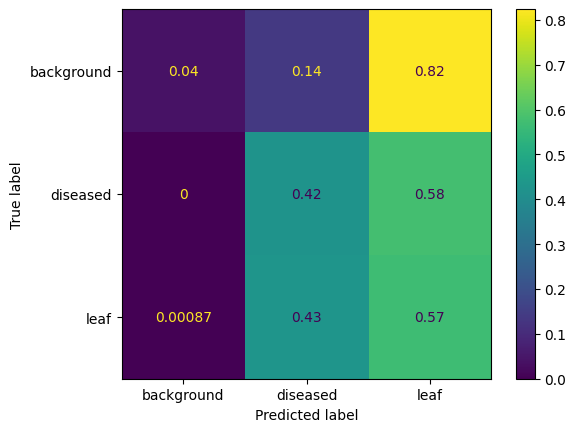

Precision: 0.521
Recall: 0.344
Overall Accuracy: 0.330


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score

def drawConfusionMatrix(actual, prediction, normalize=True, savefig=False):
    confusion_matrix = metrics.confusion_matrix(actual, prediction)
    cmn = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

    if normalize:
        confusion_matrix = cmn

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = classes)
    cm_display.plot()
    plt.show()
    precision = precision_score(actual, prediction, average='macro')
    recall = recall_score(actual, prediction, average='macro')
    accuracy = accuracy_score(actual, prediction)

    print(f'Precision: {precision:.3f}')
    print(f'Recall: {recall:.3f}')
    print(f'Overall Accuracy: {accuracy:.3f}')

    if savefig:
        plt.savefig('/content/drive/MyDrive/reallastmodelresnet/confusion_matrix.png')


drawConfusionMatrix(actual, prediction, normalize=True)

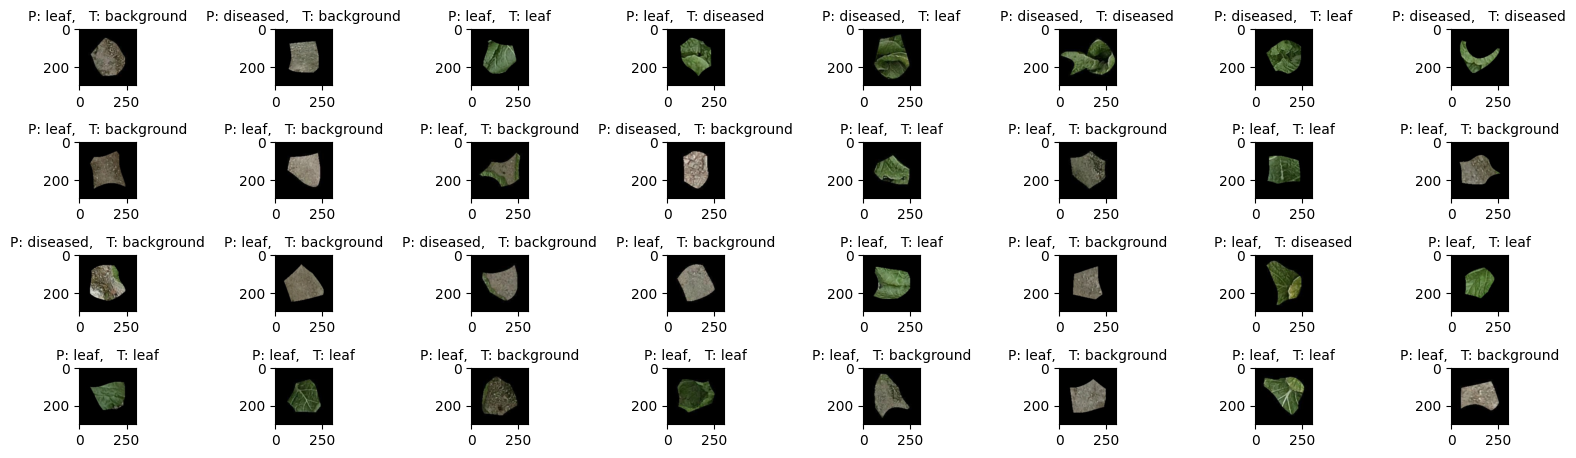

In [ ]:
def displayImgs(imgs, predicted_labels, true_labels, classes, n, save=False):
    if n > 32:
        n = 32
    fig = plt.figure(figsize=(20,11))
    for i, tensor in enumerate(imgs[:n]):
        img = torch.zeros(299, 299, 3)
        for i2, b in enumerate(range(3)):
            img[:,:,i2] = tensor[b]

        title = f"P: {classes[predicted_labels[i]]},   T: {classes[true_labels[i]]}"

        fig.add_subplot(8, 8, i + 1).set_title(title, fontsize=10)
        plt.imshow(img)
    plt.subplots_adjust(wspace=0.1, hspace=1)
    plt.show()
    if save:
        fig.savefig('/content/drive/MyDrive/reallastmodelresnet/fig.png')

with torch.no_grad():
    for x, y in train_loader:
        x = x.to(device=device)
        y = y.to(device=device)
        x_ = model(x)

        _, model_pred = x_.max(1)

        displayImgs(x, model_pred, y, classes=classes, n=batch_size)

        break

## 학습 및 검증 데이터를 통해 예측

1. f1_score 정밀도 재현율 조화평균





In [ ]:
def evaluateTorch(loader, model):
    actuals = []
    predictions = []
    evaluations = []
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, model_pred = scores.max(1)

            actuals.append(y)
            predictions.append(model_pred)

    actuals = torch.cat(actuals)
    predictions = torch.cat(predictions)

    for i in range(len(classes)):
        ac = (actuals == i)
        pr = (predictions == i)

        ca = (ac & pr).sum() / ac.sum()
        evaluations.append(ca)

    actuals = actuals.cpu().detach().numpy()
    predictions = predictions.cpu().detach().numpy()

    oa = metrics.accuracy_score(actuals, predictions)
    f1 = metrics.f1_score(actuals, predictions, average='macro')

    evaluations.append(oa)
    evaluations.append(f1)

    model.train()

    return [e.item() for e in evaluations]

print(evaluateTorch(train_loader, model), evaluateTorch(test_late_loader, model))

[0.04472003132104874, 0.4839650094509125, 0.570761501789093, 0.3407476058078468, 0.2861432359680501] [0.040109388530254364, 0.4236111044883728, 0.5696969628334045, 0.3297317436661699, 0.27040973207616054]


In [ ]:
eval_ent = [train_loader, test_late_loader]
eval_hist = [[[] for i in range(3 + len(classes))]for i in range(len(eval_ent))]
eval_idx = 1
highest_f1 = 0
b_f1 = 0
trained_epochs = 0

for epoch in range(num_epochs):
    batch_loss = np.array([])
    loop = tqdm(enumerate(train_loader), total=len(test_late_loader))

    for batch_idx, (data, targets) in loop:
        data = data.to(device=device)
        targets = targets.to(device=device)

        scores = model(data)
        loss = criterion(scores, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predictions = torch.argmax(scores, dim=1)
        loop.set_description(f"Epoch[{epoch}/{num_epochs - 1}]")

        batch_loss = np.append(batch_loss, loss.item())

    eval_hist[0][0].append(np.average(batch_loss))
    print("loss: ", eval_hist[0][0][-1]) #각 지표 하나씩 Print

    for ee, eh in zip(eval_ent, eval_hist):
        ev = evaluateTorch(ee, model)
        for i in range(len(ev)):
            eh[i + 1].append(ev[i])

    c_f1 = eval_hist[eval_idx][-1][-1]

    if (c_f1 > highest_f1): # f1_socore 가 높다면 모델 저장
        print(f"Best f1 is on {epoch} epoch")
        torch.save(model.state_dict() , f"/content/drive/MyDrive/reallastmodelresnet/Resnet_original_dataset_best{epoch}.pt")
        highest_f1 = c_f1
        b_f1 = epoch

    print("Learning rate:", optimizer.param_groups[0]['lr'])
    trained_epochs = epoch
    for i in range(3):
        print(f"accuracy_{i}: {[eval_hist[i2][i + 1][-1] for i2 in range(len(eval_ent))]}")
    for i, e in enumerate(["oa", "f1"]):
        print(f"{e}: {[eval_hist[i2][3 + i + 1][-1] for i2 in range(len(eval_ent))]}")

Epoch[0/99]: : 68it [1:06:52, 59.01s/it]


loss:  0.36880050161305594


## 훈련 기록 시각화 및 분석

In [ ]:
import pickle

with open('training_history_resnet.pckl', 'wb') as f:
    pickle.dump(eval_hist, f)

In [ ]:
import copy

# Draw training graph

def smooth(y, box_pts=5):
    y = [y[0] for i in range(box_pts)] + y + [y[-1] for i in range(box_pts)]
    box = np.ones(box_pts) / box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth[box_pts: -box_pts]

eval_hist_s = []

for data in eval_hist:
    data_c = copy.deepcopy(data)
    for i in range(len(data_c)):
        if len(data_c[i]) > 0:
            data_c[i] = smooth(data_c[i])

    eval_hist_s.append(data_c)

epochs = [e for e in range(trained_epochs + 1)]

plt.figure(figsize=(5, 10))
for i in range(num_classes):
    ax = plt.subplot(411 + i)
    ax.set_title(classes[i])
    ax.plot(epochs, eval_hist_s[0][1 + i], 'blue', label='train smooth')
    ax.plot(epochs, eval_hist[0][1 + i], 'steelblue', linestyle='dashed', label='train')

    ax.plot(epochs, eval_hist_s[1][1 + i], 'red', label='test smooth')
    ax.plot(epochs, eval_hist[1][1 + i], 'lightcoral', linestyle='dashed', label='test')

    ax.legend(loc='lower right')


plt.figure(figsize=(5, 3))
plt.plot(epochs, eval_hist_s[0][4], label='oa smothed')
plt.plot(epochs, eval_hist[0][4], linestyle='dashed', label='oa')
plt.ylim(0, 1.1)
plt.title("Overal accuracy")

## confusion Matrix 생성  

In [ ]:
actual, prediction = predictDataset(test_late_loader, model)
drawConfusionMatrix(actual, prediction, normalize=True)

In [ ]:
actual, prediction = predictDataset(test_early_loader, model)
drawConfusionMatrix(actual, prediction, normalize=True)

In [ ]:
with torch.no_grad():
    for x, y in test_early_loader:
        x = x.to(device=device)
        y = y.to(device=device)
        x_ = model(x)

        _, model_pred = x_.max(1)

        displayImgs(x, model_pred, y, classes=classes, n=batch_size)

        break

In [ ]:
test_img_late.img_df["class"].value_counts()

In [ ]:
train_img.img_df["class"].value_counts()

In [ ]:
test_img_early.img_df["class"].value_counts()

In [ ]:
test_img_late.img_df.to_csv("/content/drive/MyDrive/reallastmodelresnet/test_img_late.csv")
train_img.img_df.to_csv("/content/drive/MyDrive/reallastmodelresnet/train_img.csv")
test_img_early.img_df.to_csv("/content/drive/MyDrive/reallastmodelresnet/test_img_early.csv")